# NLP Text Classification And Recommendation System 

In [1]:
# import all necessary libraries
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer 
import string, re
from gensim.utils import simple_preprocess
import gensim
from gensim import corpora,models
from sklearn.metrics import pairwise_distances
import pickle
import spacy
from tqdm import tqdm

# show up to 300 results in both rows and columns 
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

unable to import 'smart_open.gcs', disabling that module


## Preprocessing & Cleaning

In [2]:
# load the data
df1=pd.read_csv('2019_EN_catalog_-_Jul_to_Sep.csv',encoding= 'unicode_escape')
df2=pd.read_csv('2019_EN_catalog_-_Oct_to_Dec.csv',encoding= 'unicode_escape')

In [3]:
# concat two dataframe together and reset index to ID
df=pd.concat([df1,df2], axis=0).reset_index().rename(columns={'index': 'ID'})
df.head()

,ID,Product Title,Product Author,Product Narrator,Product Publisher Name,Product Primary Category,Product Primary Sub Category,Product Long Description
0,0,'The Loudest Voice': Wondering About THAT Open...,Joyce Chen,"""""",Cosmopolitan,NaN,NaN,<p>This should help. </p>
1,1,[Clone] A Coldness in the Blood: The New Dracu...,Fred Saberhagen,Robin Bloodworth,Audible Studios,Sci-Fi & Fantasy,Fantasy: Paranormal,<p>The Bram Stoker Award-Winning saga continue...
2,2,[Clone] A Matter of Policy: An Amy Brewster My...,Sam Merwin Jr.,Janelle Bigham,Wordwooze Publishing,Mysteries & Thrillers,Suspense,<p><i>A Matter of Policy </i>is an enthralling...
3,3,[Clone] Any Way the Wind Blows: A Novel (Unabr...,E. Lynn Harris,"Dominic Hoffman, Bahni Turpin, Mirron Willis",Random House Audio,Fiction,Contemporary,"<p>At the end of <i>Not a Day Goes By</i>, the..."
4,4,[Clone] Jack & Jill (Unabridged),James Patterson,"Ron Butler, Maxwell Hamilton",Hachette Audio,Mysteries & Thrillers,Psychological,<p><b>Available as an unabridged audiobook for...


In [4]:
# check the original data shape
df.shape

(41794, 8)

In [5]:
# check if there is any missing value
df.isna().sum()

ID                                 0
Product Title                      0
Product Author                     0
Product Narrator                   0
Product Publisher Name             0
Product Primary Category        7087
Product Primary Sub Category    7087
Product Long Description        5396
dtype: int64

In [6]:
# drop nan values in product long description
df.dropna(subset = ['Product Long Description'], inplace = True)

In [7]:
# drop nan values in product primary category
df.dropna(subset = ['Product Primary Category'], inplace = True)

In [8]:
# drop unnecessary columns
df.drop(columns=[ 'Product Narrator', 'Product Publisher Name', 'Product Primary Sub Category'], inplace=True)

In [9]:
# remove unnecessary genres in product primary category
df=df[(df['Product Primary Category'] != 'Parents & Family') & (df['Product Primary Category'] != 'Products') & (df['Product Primary Category'] != 'Professionals') & (df['Product Primary Category'] != 'Students') & (df['Product Primary Category'] != 'Merchandising ') & (df['Product Primary Category'] != 'Short Stories') & (df['Product Primary Category'] != 'VERIFICATION NODES1')& (df['Product Primary Category'] != 'Merchandising')]                                                                                                                                                                                    

In [10]:
# check how the data looks like now
df.head(5)

,ID,Product Title,Product Author,Product Primary Category,Product Long Description
1,1,[Clone] A Coldness in the Blood: The New Dracu...,Fred Saberhagen,Sci-Fi & Fantasy,<p>The Bram Stoker Award-Winning saga continue...
2,2,[Clone] A Matter of Policy: An Amy Brewster My...,Sam Merwin Jr.,Mysteries & Thrillers,<p><i>A Matter of Policy </i>is an enthralling...
3,3,[Clone] Any Way the Wind Blows: A Novel (Unabr...,E. Lynn Harris,Fiction,"<p>At the end of <i>Not a Day Goes By</i>, the..."
4,4,[Clone] Jack & Jill (Unabridged),James Patterson,Mysteries & Thrillers,<p><b>Available as an unabridged audiobook for...
5,5,[Clone] The Book of Mormon (Unabridged),Joseph Smith - translator,Religion & Spirituality,<p>The Book of Mormon is a sacred text of the ...


In [11]:
# check the new shape
df.shape

(34702, 5)

In [12]:
# sort book name alphabetically
df.sort_values("Product Title", inplace = True) 

In [13]:
# remove duplicate books
df.drop_duplicates(subset ="Product Title", keep = False, inplace = True) 

In [14]:
# check the new df
df.head()

,ID,Product Title,Product Author,Product Primary Category,Product Long Description
41303,18976,"# ""No Room in the Inn?"": The Fiery Trials of L...",Brad Wyrick,Religion & Spirituality,"<p><i># ""No Room in the Inn?""</i> will take us..."
22327,0,#1 Lie (Unabridged),T. Gephart,Romance,<p>Working in Hollywood meant Jessica Dawson w...
22328,1,#1 Love (Unabridged),T. Gephart,Romance,<p>It was easy to fall in love with a Larsson ...
22329,2,#1 Muse (Unabridged),T. Gephart,Romance,<p>Landing a writing gig in Hollywood was just...
33948,11621,#1 in Customer Service: The Complete Adventure...,Larry Correia,Sci-Fi & Fantasy,"<p>No alien menace is too menacing, no galacti..."


In [15]:
# check the new shape
df.shape

(34330, 5)

In [16]:
# check if there is still missing values
df.isna().sum()

ID                          0
Product Title               0
Product Author              0
Product Primary Category    0
Product Long Description    0
dtype: int64

In [17]:
# set product long description to a short variable name
data = df['Product Long Description']

In [18]:
# create a set of stop words list
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '-', '–', '—','li','/li',"n't",
            'p','/p','/i','b','/b',"'s",'br','>','<','i','/','A','\x92','\x92s','\x92ll','.com','\x97',
           '\x97s','\x93','\x94','']
sw_set = set(sw_list)

In [19]:
# create a function to extract only nouns in nltk tokenize
def noun_article(article):
    nouns = nltk.word_tokenize(article)
    tagged = nltk.pos_tag(nouns)
    length = len(tagged) - 1
    noun_only = list()
    for i in range(0, length):
        log = (tagged [i][1][0] == 'N')
        if log == True:
            noun_only.append(tagged [i][0])
    stopwords_removed = [n.lower() for n in noun_only if n.lower() not in sw_set]
    return stopwords_removed

In [ ]:
# applying the above functions to our data 
processed_data = list(map(noun_article, data))

In [ ]:
# pickle the processed data
file = open('processed_data.p', 'wb')
pickle.dump(processed_data,file)
file.close()

In [2]:
# load pickled processed data
file = open('processed_data.p', 'rb')
processed_data = pickle.load(file)
file.close()
processed_data[:1]

[['room',
  'inn',
  'humanity',
  'garden',
  'eden',
  'believers',
  'crown-wearers',
  'heaven',
  'god\x92s',
  'word',
  'trials',
  'temptations',
  'god',
  'kingdom',
  'reward',
  'system.',
  'trials',
  'life',
  'faith',
  'character',
  'goal',
  'foremost',
  'trials',
  'way',
  'god\x92s',
  'plan',
  'purpose',
  'lives',
  'satan\x92s',
  'weapon',
  'ignorance',
  'god\x92s',
  'word',
  'scriptural',
  'truth',
  'threshold',
  'decision',
  'life',
  'promises',
  'principles',
  'provisions',
  'will.',
  'scripture',
  'spirit',
  'fellowship',
  'suffering',
  'image',
  'power',
  'resurrection',
  'path',
  'life',
  'jesus',
  'word',
  'fact',
  'word.',
  'furthermore',
  'room',
  'inn',
  'jesus',
  'didn\x92t',
  'purpose',
  'remember',
  'innkeeper',
  'heart',
  'vacancy',
  'sign.']]

In [21]:
# check the total count of words in processed data
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

87859

In [22]:
# join strings in processed data to one long string
new_processed_data = [' '.join(w) for w in processed_data]
new_processed_data[:1]

['room inn humanity garden eden believers crown-wearers heaven god\x92s word trials temptations god kingdom reward system. trials life faith character goal foremost trials way god\x92s plan purpose lives satan\x92s weapon ignorance god\x92s word scriptural truth threshold decision life promises principles provisions will. scripture spirit fellowship suffering image power resurrection path life jesus word fact word. furthermore room inn jesus didn\x92t purpose remember innkeeper heart vacancy sign.']

In [23]:
# create a function to exclude all html format
def article(text):
    text = re.sub(r'\<[\w/]+\>', '', text)
    text = text.replace("</p>",'')
    text = text.replace("<p>",'')
    text = text.replace("</ul>",'')
    text = text.replace("<ul>",'')
    text = text.replace("</li>",'')
    text = text.replace("<li>",'')
    text = text.replace("</i>",'')
    text = text.replace("<i>",'')
    text = text.replace("</b>",'')
    text = text.replace("<b>",'')
    text = text.replace("</>",'')
    text = text.replace("\'s",'')
    text = text.replace("\'t",'')
    text = text.replace("\'ll",'')
    text = text.replace("\x92",'')
    text = text.replace("\x92s",'')
    text = text.replace("\x92t",'')
    text = text.replace("\x93",'')
    text = text.replace("\x94",'')
    text = text.replace("\x91",'')
    text = text.replace("\x97",'')
    text = text.replace("\x85",'')
    text = text.replace("\xa0",'')
    text = text.replace("/ul",'')
    text = text.replace("(Unabridged)",'')
    text = text.replace("#",'')
    text = text.replace("[Clone]",'')
    return text

In [24]:
# apply the above function to both book title and book description
new_title_list = list(map(article,df['Product Title']))
new_discription_list = list(map(article,df['Product Long Description']))

In [25]:
# turn both title list and discription list to dataframe
new_title = pd.DataFrame(new_title_list)
new_diccription = pd.DataFrame(new_discription_list)

In [26]:
# replace both original product title and product long discription by new cleaned title and description
df['Product Title'] = new_title
df['Product Long Description'] = new_diccription

In [27]:
# check the final df
df.head()

,ID,Product Title,Product Author,Product Primary Category,Product Long Description
41303,18976,NaN,Brad Wyrick,Religion & Spirituality,NaN
22327,0,Scientists Predict Climate Change Will Make Da...,T. Gephart,Romance,Climate change will make dangerous heat waves ...
22328,1,Scientists Say They've Identified the Earliest...,T. Gephart,Romance,Scientists say they've identified the earliest...
22329,2,Scientists Unveil Memorial to Iceland 'First' ...,T. Gephart,Romance,Iceland is mourning the loss of one of it famo...
33948,11621,Written!,Larry Correia,Sci-Fi & Fantasy,Grandmaster Caz is a pioneering legend who can...


In [ ]:
# pickle the final dataframe
file = open('df.p', 'wb')
pickle.dump(df,file)
file.close()

In [3]:
# load pickled final dataframe
file = open('df.p', 'rb')
df = pickle.load(file)
file.close()
df.head()

,ID,Product Title,Product Author,Product Primary Category,Product Long Description,word_count
0,18976,"""No Room in the Inn?"": The Fiery Trials of Li...",Brad Wyrick,Religion & Spirituality,"""No Room in the Inn?"" will take us from human...",227
1,0,1 Lie,T. Gephart,Romance,Working in Hollywood meant Jessica Dawson was ...,240
2,1,1 Love,T. Gephart,Romance,It was easy to fall in love with a Larsson - s...,196
3,2,1 Muse,T. Gephart,Romance,Landing a writing gig in Hollywood was just as...,327
4,11621,1 in Customer Service: The Complete Adventures...,Larry Correia,Sci-Fi & Fantasy,"No alien menace is too menacing, no galactic r...",280


### Lemmatization

In [ ]:
# apply remove html function on processed data
final_noun_list = list(map(article, new_processed_data))

In [ ]:
# prepare to lemmatize
lemmatizer = WordNetLemmatizer() 

In [ ]:
# creating a list with all lemmatized outputs in final noun list
lemmatized_output = []
for listy in final_noun_list:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy.split()])
    lemmatized_output.append(lemmed)

In [ ]:
# set the lemmatized outputs to a variable name 
final_noun_list_lemmatizd = lemmatized_output

In [ ]:
# pickle the lemmatized outputs
file = open('final_noun_list_lemmatizd.p', 'wb')
pickle.dump(final_noun_list_lemmatizd,file)
file.close()

In [ ]:
# load pickled lemmatized outputs
file = open('final_noun_list_lemmatizd.p', 'rb')
final_noun_list_lemmatizd = pickle.load(file)
file.close()

In [4]:
# check the final book description paragraphs
final_noun_list_lemmatizd[:1]

['room inn humanity garden eden believer crown-wearers heaven god word trial temptation god kingdom reward system. trial life faith character goal foremost trial way god plan purpose life satan weapon ignorance god word scriptural truth threshold decision life promise principle provision will. scripture spirit fellowship suffering image power resurrection path life jesus word fact word. furthermore room inn jesus didnt purpose remember innkeeper heart vacancy sign.']

## EDA

In [30]:
# set product primary category values to a short variable name 
labels = df['Product Primary Category'].values

In [31]:
# check the sorted value counts in product primary category
df['Product Primary Category'].value_counts().sort_values(ascending=False)

Self Development           4782
Romance                    4501
Newspapers & Magazines     3290
Mysteries & Thrillers      2693
Sci-Fi & Fantasy           2604
Fiction                    1950
Teens                      1785
Religion & Spirituality    1509
Science & Technology       1409
Business                   1380
Kids                       1213
Nonfiction                 1117
Erotica & Sexuality         961
Bios & Memoirs              954
History                     902
Health & Fitness            752
Sports                      527
Arts & Entertainment        411
Nostalgia Radio             338
Classics                    337
Language Instruction        224
Drama & Poetry              204
Travel & Adventure          163
Comedy                      121
Radio & TV                  109
Live Events                  61
Kids & Young Adults          33
Name: Product Primary Category, dtype: int64

Text(0.5, 1.0, 'Distribution Of Genres')

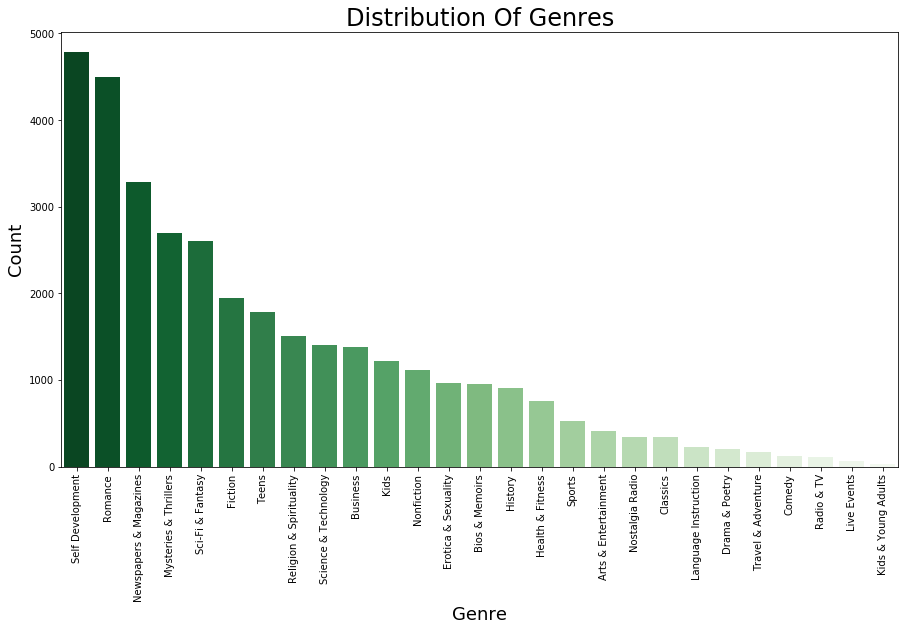

In [32]:
# plot distribution of genres in descending
plt.figure(figsize = (15,8))
g=sns.countplot(x =labels, palette="Greens_r",order = df['Product Primary Category'].value_counts().index)
g.set(xticklabels=['Self Development', 'Romance', 'Newspapers & Magazines','Mysteries & Thrillers','Sci-Fi & Fantasy','Fiction','Teens','Religion & Spirituality','Science & Technology','Business','Kids','Nonfiction','Erotica & Sexuality','Bios & Memoirs','History','Health & Fitness','Sports','Arts & Entertainment','Nostalgia Radio','Classics','Language Instruction','Drama & Poetry','Travel & Adventure','Comedy','Radio & TV','Live Events','Kids & Young Adults'])
plt.xticks(rotation=90)
plt.xlabel('Genre',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.title('Distribution Of Genres', fontsize=24)

In [33]:
# calculate word counts in product long description
word_count = df['Product Long Description'].apply(lambda x:len(x.split()))
print('mean:', word_count.mean())
print('25 quantile:', word_count.quantile(0.25))
print('75 quantile:', word_count.quantile(0.75))

mean: 157.47838625109233
25 quantile: 85.0
75 quantile: 225.0


Text(0.5, 1.0, 'Average word count in book discription ')

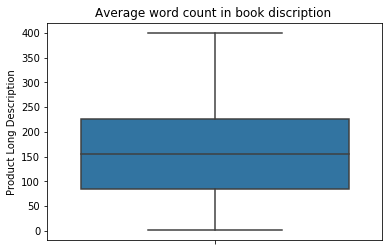

In [34]:
# plot the above numbers
sns.boxplot(y=word_count, showfliers=False)
plt.title('Average word count in book discription ')

In [35]:
# create new word count column in df
df['word_count'] = word_count
df.head()

,ID,Product Title,Product Author,Product Primary Category,Product Long Description,word_count
0,18976,"""No Room in the Inn?"": The Fiery Trials of Li...",Brad Wyrick,Religion & Spirituality,"""No Room in the Inn?"" will take us from human...",227
1,0,1 Lie,T. Gephart,Romance,Working in Hollywood meant Jessica Dawson was ...,233
2,1,1 Love,T. Gephart,Romance,It was easy to fall in love with a Larsson - s...,196
3,2,1 Muse,T. Gephart,Romance,Landing a writing gig in Hollywood was just as...,318
4,11621,1 in Customer Service: The Complete Adventures...,Larry Correia,Sci-Fi & Fantasy,"No alien menace is too menacing, no galactic r...",279


Text(0, 0.5, 'word count')

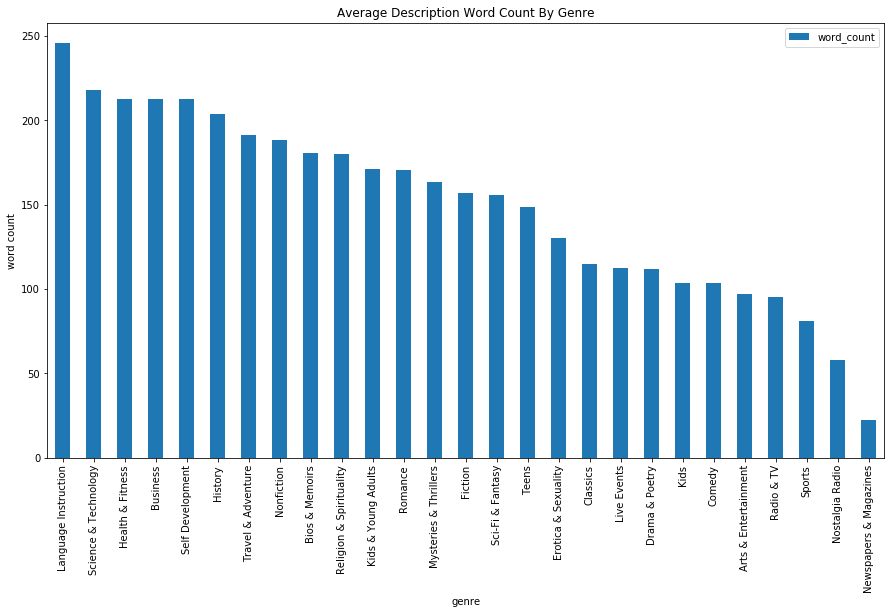

In [36]:
# group average word count by genre and visualize it in descending
a=df.groupby(['Product Primary Category'])['word_count'].mean()
ax = pd.DataFrame(a.sort_values(ascending=False)).plot(kind='bar',figsize =(15,8),use_index=bool,title='Average Description Word Count By Genre')
ax.set_xlabel('genre')
ax.set_ylabel('word count')

In [37]:
# make the above graph to a dataframe 
pd.DataFrame(a.sort_values(ascending=False)).head()

,word_count
Product Primary Category,
Language Instruction,245.593750
Science & Technology,217.887154
Health & Fitness,212.671543
Business,212.581159
Self Development,212.431828


In [38]:
# randomly select 1000 observations in df
eda = df.sample(n=1000, replace=False, random_state=10)

In [39]:
# join strings in smapledf product long description to one long string
total_description=[]
for i in eda['Product Long Description']:
    total_description.append(i)
    list_to_str = ' '.join([str(elem) for elem in total_description])
list_to_str[:44]                   

'Do you want to learn about dialysis recipes?'

In [40]:
# tokenize the above string
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
tokenized_review = tokenizer.tokenize(list_to_str)

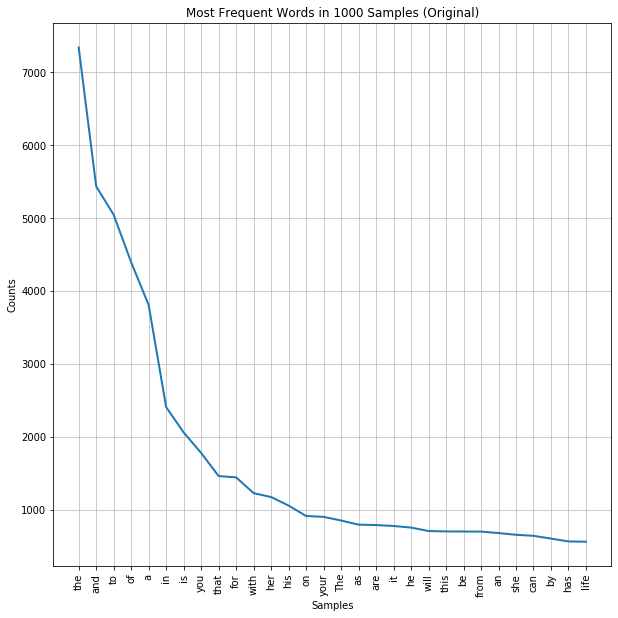

In [41]:
# plot the 30 most frequent words in sampledf product long description
fdist = FreqDist(tokenized_review)
plt.figure(figsize=(10,10))
plt.title('Most Frequent Words in 1000 Samples (Original)')
fdist.plot(30)

In [42]:
# apply noun only function on sampledf product long description
noun_list = noun_article(list_to_str)

In [43]:
# join strings in above list to one long string
list_to_str2 = ' '.join([str(elem) for elem in noun_list])
list_to_str2[:17]

'dialysis recipes '

In [44]:
# tokenize the above string
tokenized_review2 = tokenizer.tokenize(list_to_str2)

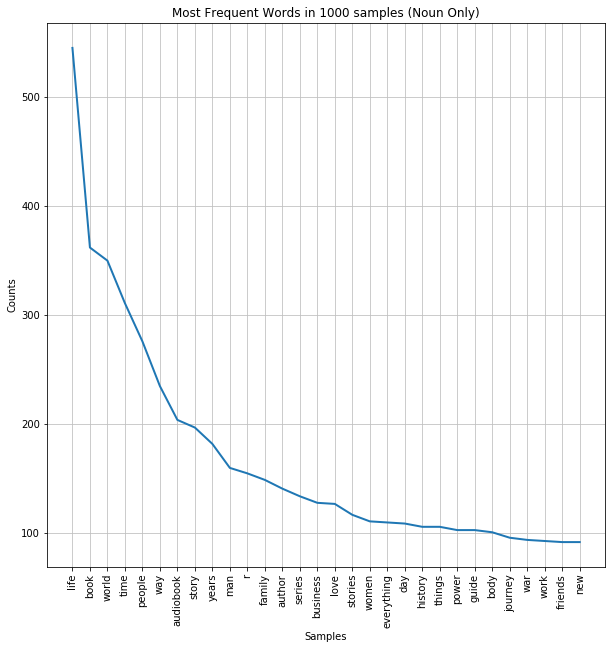

In [45]:
# plot the 30 most frequent noun only words in sampledf product long description
fdist2 = FreqDist(tokenized_review2)
plt.figure(figsize=(10,10))
plt.title('Most Frequent Words in 1000 samples (Noun Only)')
fdist2.plot(30)

### Most Frequent Words

In [46]:
# Try to compare fiction vs nonfiction
df_freq_ficiton = df[df['Product Primary Category']=='Fiction']
df_freq_nonficiton = df[df['Product Primary Category']=='Nonfiction']

In [47]:
# get discriptions from fiction and nonfiction
data_fiction = df_freq_ficiton['Product Long Description']
data_nonfiction = df_freq_nonficiton['Product Long Description']

In [48]:
# apply noun only function to fiction and nonfiction description
pros_fiction = list(map(noun_article, data_fiction))
pros_nonfiction = list(map(noun_article, data_nonfiction))

In [49]:
# check the total count of words in fiction and nonfiction
total_vocab_fiction = set()
total_vocab_nonfiction = set()
for comment in pros_fiction:
    total_vocab_fiction.update(comment)
for comment in pros_nonfiction:
    total_vocab_nonfiction.update(comment)
print('total vocabulary in fiction:',len(total_vocab_fiction))
print('total vocabulary in nonfiction:',len(total_vocab_nonfiction))

total vocabulary in fiction: 19643
total vocabulary in nonfiction: 14906


In [50]:
# check sample words in fiction
print(pros_fiction[:1])

[['climate', 'change', 'water', 'crisis', 'china', 'prairie', 'provinces', 'river', 'water', 'hudson', 'bay', 'beijing', 'passage', 'year-round', 'story', 'insights', 'canada', 'water', 'resources', 'geography', 'history.environmentalists', 'north', 'canada', 'water', 'resources', 'jeremiah', 'coffey', 'us', 'presidentis', 'chinese', 'canada', 'columbia', 'united', 'states', 'drought', 'americans', 'water', 'california', 'british', 'columbia', 'rivers', 'us', 'state', 'department', 'cia', 'tactics', 'lee', 'girard', 'asset', 'field.the', 'green', 'party', 'power', 'months', 'sheila', 'thompson', 'prime', 'minister', 'canada', 'chinese', 'occupation', 'meddling', 'minister', 'national', 'defence', "'rolly", "o'brien", 'salty', 'newfoundlander', 'korean', 'chief', 'defence', 'staff', 'general', 'robert', 'fraser', 'husband', 'to-be', 'staff', 'stuart', 'mcgee', 'everything', 'plan', 'chinese', 'remembrance', 'day.the', 'british', 'prime', 'minister', 'post', 'brexit', 'woes', 'collapse',

In [51]:
# check sample words in nonfiction
print(pros_nonfiction[:1])

[['milestone', 'crime', 'hall-mills', 'case', 'new', 'brunswick', 'new', 'jersey', 'decade', 'killer', 'case', 'aficionados.a', 'bon', 'vivant', 'episcopal', 'minister', 'soprano', 'choir', 'wife', 'brother', 'maid', 'snooping', 'congregants', 'bumbling', 'detectives', 'denouement', 'trial', 'americas', 'jazz', 'age', 'likes', 'damon', 'runyon', 'dorothy', 'dix', 'james', 'thurber', 'testimony', 'witness', 'veracity', 'farmer', 'tabloids', 'pig', 'woman', 'almost', 'everyone', 'mystery', 'secret', 'one', 'years', 'audibles', 'request', 'business', 'crime', 'journalist', 'bryan', 'burrough', 'case', 'records', 'time', 'narration', 'texas', 'accent', 'immediacy', 'intimacy', 'new', 'jersey', 'crime', 'listeners', 'reconstruction', 'double-murderand', 'prosecution', 'media', 'circus', 'day']]


In [52]:
# preprocess the data before calculating frequency 
flat_fiction = [item for sublist in pros_fiction for item in sublist]
flat_nonfiction = [item for sublist in pros_nonfiction for item in sublist]

In [53]:
# apply freqent funtions to above lists
fiction_freq = FreqDist(flat_fiction)
nonfiction_freq = FreqDist(flat_nonfiction)

In [54]:
# check top 20 fiction words
fiction_freq.most_common(20)

[('life', 1206),
 ('story', 763),
 ('family', 736),
 ('man', 637),
 ('world', 630),
 ('love', 514),
 ('time', 507),
 ('stories', 477),
 ('novel', 459),
 ('book', 432),
 ('author', 426),
 ('years', 398),
 ('woman', 368),
 ('war', 362),
 ('home', 357),
 ('way', 341),
 ('new', 318),
 ('father', 315),
 ('mother', 306),
 ('town', 286)]

In [55]:
# check top 20 nonfiction words
nonfiction_freq.most_common(20)

[('book', 601),
 ('world', 491),
 ('people', 417),
 ('history', 402),
 ('life', 386),
 ('story', 351),
 ('women', 311),
 ('years', 307),
 ('time', 285),
 ('america', 275),
 ('trump', 239),
 ('new', 237),
 ('audiobook', 232),
 ('author', 231),
 ('stories', 213),
 ('power', 203),
 ('way', 201),
 ('war', 172),
 ('states', 171),
 ('work', 169)]

### Normalized Word Frequencies

In [56]:
# normalize top 20 fiction words to percentage
fiction_total_word_count = sum(fiction_freq.values())
fiction_top_20 = fiction_freq.most_common(20)
print("Word \t\t Normalized Frequency")
print()
for word in fiction_top_20:
    normalized_frequency = word[1]/fiction_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

life 		 0.01243
story 		 0.007867
family 		 0.007588
man 		 0.006568
world 		 0.006495
love 		 0.005299
time 		 0.005227
stories 		 0.004918
novel 		 0.004732
book 		 0.004454
author 		 0.004392
years 		 0.004103
woman 		 0.003794
war 		 0.003732
home 		 0.003681
way 		 0.003516
new 		 0.003279
father 		 0.003248
mother 		 0.003155
town 		 0.002949


In [57]:
# normalize top 20 nonfiction words to percentage
nonfiction_total_word_count = sum(nonfiction_freq.values())
nonfiction_top_20 = nonfiction_freq.most_common(20)
print("Word \t\t Normalized Frequency")
print()
for word in nonfiction_top_20:
    normalized_frequency = word[1]/nonfiction_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

book 		 0.008764
world 		 0.00716
people 		 0.006081
history 		 0.005862
life 		 0.005629
story 		 0.005119
women 		 0.004535
years 		 0.004477
time 		 0.004156
america 		 0.00401
trump 		 0.003485
new 		 0.003456
audiobook 		 0.003383
author 		 0.003369
stories 		 0.003106
power 		 0.00296
way 		 0.002931
war 		 0.002508
states 		 0.002494
work 		 0.002465


### visualization

In [58]:
# create counts of fiction and nonfiction with values and words
fiction_bar_counts = [x[1] for x in fiction_freq.most_common(20)]
fiction_bar_words = [x[0] for x in fiction_freq.most_common(20)]
nonfiction_bar_counts = [x[1] for x in nonfiction_freq.most_common(20)]
nonfiction_bar_words = [x[0] for x in nonfiction_freq.most_common(20)]

In [59]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

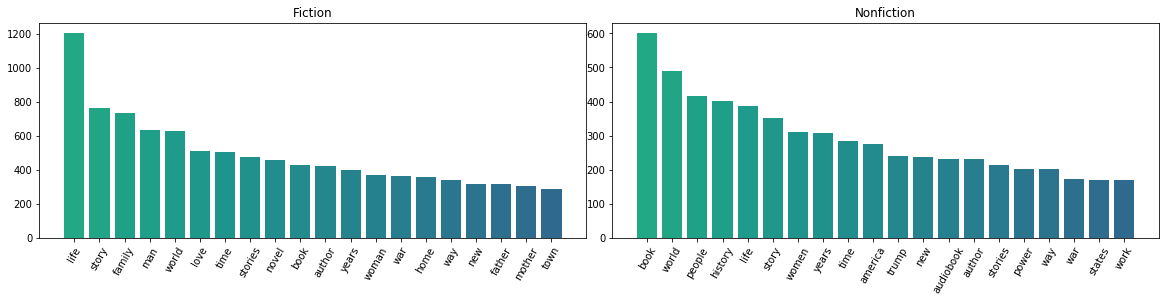

In [60]:
# visualize the result in descending
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

ax.bar(fiction_bar_words, fiction_bar_counts, color=color)

ax2.bar(nonfiction_bar_words, nonfiction_bar_counts, color=color )

ax.title.set_text('Fiction')
ax2.title.set_text('Nonfiction')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

plt.show()

### Word Clouds

In [61]:
# set fiction and nonfiction words to dictionary
fiction_dictionary = dict(zip(fiction_bar_words, fiction_bar_counts))
nonfiction_dictionary = dict(zip(nonfiction_bar_words, nonfiction_bar_counts))

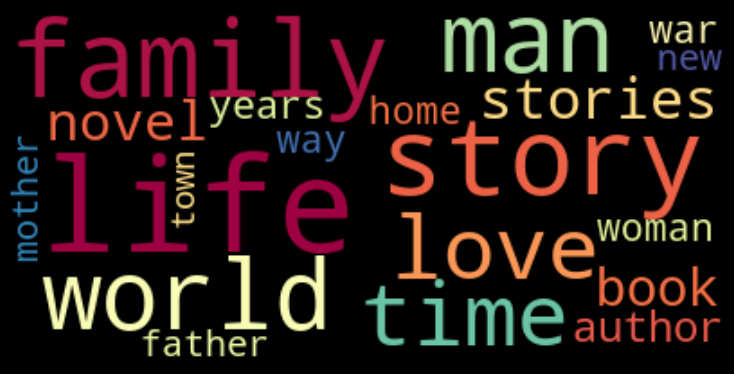

In [62]:
# create the fiction word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(fiction_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

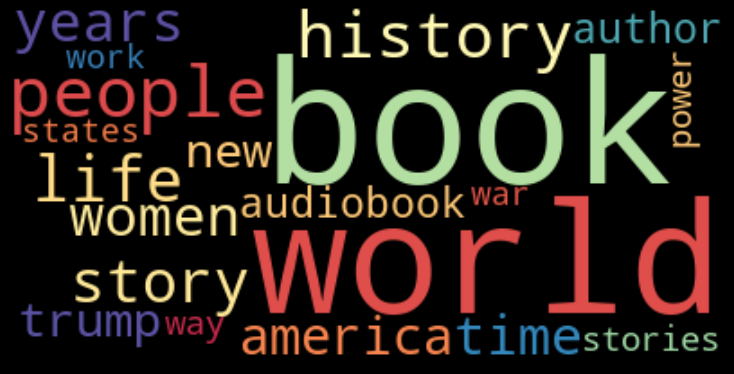

In [63]:
# Create the nonfiction word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(nonfiction_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

##  Recommendation System

### Gensim Corpus Model

In [23]:
# check the lemmatized final noun list again
final_noun_list_lemmatizd[:1]

['room inn humanity garden eden believer crown-wearers heaven god word trial temptation god kingdom reward system. trial life faith character goal foremost trial way god plan purpose life satan weapon ignorance god word scriptural truth threshold decision life promise principle provision will. scripture spirit fellowship suffering image power resurrection path life jesus word fact word. furthermore room inn jesus didnt purpose remember innkeeper heart vacancy sign.']

In [24]:
# create a function to tokenize
def preprocess_body(text):
    simple_text = simple_preprocess(text)
    text_out = [ word for word in simple_text ]
    return text_out

In [25]:
# apply lemmatized final noun list to above function
list_of_word_token = list(map(preprocess_body, final_noun_list_lemmatizd))

In [26]:
# apply gensim corpus to create a dictionary and apply filter on tokenized final nouns
id2word = corpora.Dictionary(list_of_word_token)
id2word.filter_extremes(no_below=30,no_above=0.5,keep_n=10000)
texts = list_of_word_token
corpus = [id2word.doc2bow(text) for text in texts]

In [27]:
# check the length of rows and columns
print('word count in id2word:',len(id2word))
print('word coint in texts:',len(texts))

word count in id2word: 5273
word coint in texts: 34330


In [28]:
# create a corpus dataframe 
corpusdf=pd.DataFrame(gensim.matutils.corpus2dense(corpus,num_terms=5273,num_docs=34330)).T

In [29]:
# set columns to tokenized words
corpusdf.columns=id2word.token2id

In [30]:
# set book title to original product title
corpusdf['book_title']=df['Product Title']

In [ ]:
# pickle the corpusdf
file = open('corpusdf.p', 'wb')
pickle.dump(corpusdf,file)
file.close()

In [5]:
# load pickled corpusdf
file = open('corpusdf.p', 'rb')
corpusdf = pickle.load(file)
file.close()
corpusdf.head()

,believer,character,crown,decision,didnt,eden,fact,faith,foremost,furthermore,garden,goal,god,heart,heaven,humanity,ignorance,image,inn,jesus,kingdom,life,path,plan,power,principle,promise,purpose,remember,resurrection,reward,room,satan,scripture,sign,spirit,suffering,system,temptation,trial,truth,way,weapon,will,word,agent,assistant,brother,charm,cousin,dave,dawson,enter,family,fast,funny,hollywood,home,jessica,lay,lie,man,mate,meant,month,occurrence,one,professional,reality,recovery,sexy,sibling,solution,soul,talent,thing,time,tongue,town,wedding,adolescent,alex,boy,city,criminal,crush,degree,friend,friendship,hed,job,la,law,love,maya,memory,mistress,oh,possibility,relationship,risk,shed,side,them,well,yeah,actor,amazing,anyone,apartment,beauty,belief,body,bound,claire,comprehension,convince,cookie,creepy,cue,dream,face,fan,fiction,forget,getting,gig,good,hell,insanity,installment,looking,lot,material,moment,name,nick,opportunity,order,panic,participant,pleasure,proportion,rejection,rise,roommate,sense,series,something,stalker,...,lit,supremacy,fearless,niece,breathless,vendetta,enforcer,same,astrology,visionary,carbohydrate,pitch,magician,destroy,digest,proposition,narcissism,narcissist,carbs,guesswork,quickly,initiation,empaths,becky,karma,wale,championship,mlb,exhaustion,booker,financing,mini,dairy,paige,berry,rocket,goals,burst,delusion,triad,exit,canine,stint,enneagram,stoicism,gaze,claw,carson,she,fifth,fluff,organizations,radiation,dinosaur,cognitive,clutter,cambridge,couldnt,joel,witchcraft,limits,sociopath,mist,coordinator,mccartney,succubus,butterfly,accuracy,recruit,nba,certainty,diverse,climax,sisterhood,congregation,clean,beware,garrett,scenes,alignment,consent,kinky,knack,shane,drunk,cherry,brighter,invest,macabre,mastermind,miner,storyline,blogging,objection,undead,mishap,natalie,manipulator,roadblock,heist,whiskey,panel,stacey,brainwashing,realize,capitalism,lyric,jade,neglect,popular,beating,intellect,defender,nikki,enhance,newbie,shipping,creating,massage,throw,leather,poignant,dale,nanotechnology,homework,claudia,kristy,stoic,narcissistic,empath,dependence,stats,foolproof,gwen,sharing,betschen,couch,venice,eq,bollywood,espn,ncaaf,foxnews,affairs,fuzzy,hindustan,latest,wiccan,columnists,book_title
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""No Room in the Inn?"": The Fiery Trials of Li..."
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### Cosine Similarity

In [6]:
# apply cosine similarity to corpusdf
cosine_sim = 1-pairwise_distances(corpusdf.drop(columns='book_title'), metric='cosine',n_jobs=-1)

In [7]:
# make above results to dataframe
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,...,34180,34181,34182,34183,34184,34185,34186,34187,34188,34189,34190,34191,34192,34193,34194,34195,34196,34197,34198,34199,34200,34201,34202,34203,34204,34205,34206,34207,34208,34209,34210,34211,34212,34213,34214,34215,34216,34217,34218,34219,34220,34221,34222,34223,34224,34225,34226,34227,34228,34229,34230,34231,34232,34233,34234,34235,34236,34237,34238,34239,34240,34241,34242,34243,34244,34245,34246,34247,34248,34249,34250,34251,34252,34253,34254,34255,34256,34257,34258,34259,34260,34261,34262,34263,34264,34265,34266,34267,34268,34269,34270,34271,34272,34273,34274,34275,34276,34277,34278,34279,34280,34281,34282,34283,34284,34285,34286,34287,34288,34289,34290,34291,34292,34293,34294,34295,34296,34297,34298,34299,34300,34301,34302,34303,34304,34305,34306,34307,34308,34309,34310,34311,34312,34313,34314,34315,34316,34317,34318,34319,34320,34321,34322,34323,34324,34325,34326,34327,34328,34329
0,1.000000,0.104062,0.089893,0.085280,0.006443,0.055419,0.023652,0.020328,0.152894,0.074796,0.079455,0.165468,0.048436,0.007734,0.017336,0.071067,0.101929,0.115122,0.000000,0.000000,0.127128,0.0,0.0,0.0,0.0,0.033710,0.000000,0.000000,0.0,0.038925,0.038925,0.000000,0.138343,0.0,0.0,0.041503,0.000000,0.038925,0.000000,0.0,0.000000,0.029822,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.038925,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.058092,0.013621,0.0,0.036038,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.033478,0.000000,0.000000,0.000,0.0,0.000000,0.00000,0.0,0.036038,0.00,0.00,0.0,0.170561,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.234521,0.0,0.0,0.062238,0.0,0.015268,0.016116,0.047673,0.082988,0.008206,0.000000,0.000000,0.018789,...,0.086926,0.000000,0.000000,0.070821,0.016116,0.023125,0.000000,0.029781,0.000000,0.000000,0.057496,0.000000,0.062065,0.139455,0.0,0.000000,0.091475,0.000000,0.104017,0.018019,0.0,0.051793,0.145260,0.137870,0.120437,0.131387,0.000000,0.000000,0.036781,0.000000,0.040889,0.010342,0.000000,0.177072,0.010796,0.072075,0.176547,0.030667,0.203739,0.074453,0.072075,0.115320,0.000000,0.044947,0.000000,0.071067,0.044638,0.000000,0.059591,0.042471,0.071870,0.016855,0.000000,0.064875,0.058849,0.000000,0.007107,0.0,0.123858,0.0,0.111717,0.031782,0.059696,0.010660,0.106600,0.090094,0.051793,0.106809,0.249675,0.245508,0.229341,0.117363,0.045512,0.049237,0.000000,0.121090,0.012208,0.089343,0.0,0.000000,0.000000,0.011562,0.418674,0.060640,0.053405,0.000000,0.011237,0.174991,0.14058,0.121356,0.005241,0.170941,0.008969,0.034816,0.041613,0.000000,0.0,0.000000,0.023977,0.088273,0.029781,0.013222,0.028748,0.013484,0.150756,0.000000,0.000000,0.093187,0.071870,0.109370,0.072897,0.032947,0.014253,0.000000,0.014020,0.033710,0.066742,0.024618,0.000000,0.013294,0.104031,0.000000,0.000000,0.000000,0.262487,0.055048,0.0,0.0,0.0,0.000000,0.018789,0.000000,0.0,0.0,0.036038,0.00,0.0,0.000000,0.0,0.0,0.000000,0.033710,0.033710,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.104062,1.000000,0.085749,0.119312,0.016389,0.070485,0.180497,0.025854,0.113436,0.023783,0.060634,0.078920,0.030802,0.108197,0.055122,0.054233,0.064820,0.053244,0.000000,0.000000,0.040423,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.099015,0.099015,0.000000,0.079179,0.0,0.0,

In [8]:
# create a book title column equals to coupusdf book title
cosine_sim_df['book_title'] = corpusdf['book_title']

In [9]:
# set index to coupusdf book title
cosine_sim_df.set_index('book_title', inplace = True)

In [10]:
# set dataframe columns to coupusdf book title
cosine_sim_df.columns = corpusdf['book_title']

In [11]:
# check cosine similarity dataframe
cosine_sim_df.head()

book_title,"""No Room in the Inn?"": The Fiery Trials of Life Prepare and Protect the Pathway to Your Heavenly Mansion",1 Lie,1 Love,1 Muse,1 in Customer Service: The Complete Adventures of Tom Stranger,"Blessed by Malakai: To Marry a Madden Series, Book 1","Claimed by Crayson: To Marry a Madden Series, Book 2","GoodGirlBadBoy: BestFriendsForever Series, Book 3","HateThatBoy: BestFriendsForever Series, Book 2",Hey You! Moments to Remember,"Lazarus10: Lake Pen Series, Book 1",LoveJustLove,"PrankLove in Blue: LovePranks Series, Book 3","Royal: Fever Falls, Book 4",Side Hustle: An Entrepreneur's Guide to Building Passive Income From Unexpected Ideas,"TheRealCinderella: BestFriendsForever Series, Book 1",ThisIsBrokering,"instalovers: Digital dating, DM disasters & love stories + 10 romance fueling recipes","$10,000 Gold: Why Gold's Inevitable Rise Is the Investor's Safe Haven",'A Momentous Time For Survivors.' Hundreds of Sex Abuse Lawsuits Anticipated Today After New York State Passes Child Victims Legislation,'A Platform for Dialogue.' Hong Kong's Leader Promises to Listen to a Community Torn Apart by Protest,'A Very Volatile Situation': At Least 6 Police Officers Injured in Philadelphia Shooting,'A Very Volatile Situation.' Gunman in Custody After Wounding at Least Six Police Officers in Philadelphia Shooting,'Amazon. Try Not to Think About It.' John Oliver Celebrates Amazon Prime Day on Last Week Tonight,'An Absurd Discussion.' Denmark's Prime Minister Dismisses President Trump's Interest in Purchasing Greenland,'Any Attempt to Play With Fire Will Only Backfire.' Beijing Issues Stern Warning to Hong Kong Protesters,"'Anything That Moves the Ball Forward.' Some Green New Deal Supporters Back Carbon Tax, Too",'Aquaman' Star Jason Momoa Visits Protesters of Giant Hawaiian Telescope,'Chatgate' Scandal Plunges Puerto Rico Governor Into Political Crisis,'Deport Hate.' Muslim Virginia Lawmaker Heckles Trump During Jamestown Speech,'Deport Hate.' Virginia Lawmaker Heckles Trump During Jamestown Speech,'Desire Is Always Evolving.' What the 'Three Women' Author Learned After a Decade Following Women's Sex Lives,'Didychrislito': The Haiti earthquake had a massive impact on me,'Do Not Travel Due to Crime and Kidnapping.' Here's Where the U.S. Is Sending Asylum Seekers,'El Paso Is the Strongest Place in the World.' Beto O'Rourke Halts Campaign to Rush Home After Walmart Shooting,'Fetchers of Water': The Panda-Polar Bear War,"'Good Guys With Guns' Can Rarely Stop Mass Shootings, and Texas and Ohio Show Why",'Growing Wave of Support on Both Sides of the Aisle.' New 'Red Flag' Gun Control Proposal Gains Momentum in Senate,'He Was Just a Kid.' El Paso School Mourns Shooting Victim as Teachers Console Students Citywide,'He Was Such a Happy Kid.' What to Know About the 3 Victims of the Gilroy Festival Shooting,'He's Got His Own Style.' Handsome Goat Is One of the Most Stylish Guys to Grace Your Eyeballs Lately,"'Her' Revenge: She Knows, Book 4",'How as a Community Can We Move Forward?' Uncertainty Lingers After Mississippi ICE Raids,"'I Am Very Much Alive': Ruth Bader Ginsburg Discusses Her Health, the Late Justice Stevens and Court Packing",'I Believe in My Work.' How Rep. Ilhan Omar Rose From Refugee to Trump's Top Target,'I Don't Think We're Having a Recession.' Trump Offers an Optimistic Outlook for the Economy,'I Feel Like Jay-Z Can Bring Back Colin Kaepernick.' Celebrities Weigh in on Jay Z's New NFL Deal,'I Get to Hug Them All the Time.' What It's Like to Take Care of a Pair of History-Making Panda Cubs,"'I Have Lived in Repentance for the Past Several Years.' Megachurch Pastor, Purity Advocate Says He's No Longer Christian","'I Have Never Felt the Need to Enact Any Kind of Violence.' Pro Gamers Say Guns, Not Games, Are to Blame for Shootings",'I Have Only One More Test to Pass.' The Enduring Message of the Last Letters From WWII's Captured French Resisters,'I Just Have to Quit Equinox.' Fitness Instructors and Influencers Are Furious Ove

In [12]:
# check if there is any duplicate books
cosine_sim_df.index.is_unique

True

In [13]:
# randomly check one book and its top 5 recommendation
cosine_sim_df.iloc[9].sort_values(ascending=False).head(6)

book_title
Hey You! Moments to Remember                                              1.000000
Nine Carpe Diem Poems                                                     0.416025
My Short Life as a Zombie                                                 0.396297
Mundane to Magical: Creating Moments of Awareness in Everyday Life        0.373490
Listen to the Word, Volume 1: Daily Devotional Bible Listening Program    0.364769
 Lineage: A Beginning                                                     0.359937
Name: Hey You! Moments to Remember , dtype: float32

In [29]:
# create a box to let user input books' name (need a space after book name)
user_book = str(input("Give a book name?"))

Give a book name?1 Story Ticket: After Dinner 


In [30]:
# create a function to return top 5 recommendations based on given book
def get_rec(userChoice,cosine_sim_df):
    for i in cosine_sim_df.index:
        if user_book == i:
            return cosine_sim_df[user_book].sort_values(ascending= False)[1:6]

In [31]:
# show recommendation results
print('Top 5 book recommendation for you:')
print(get_rec(user_book,cosine_sim_df))

Top 5 book recommendation for you:
book_title
1 Story Ticket: Campfire Stories                                                                                                 0.730798
Bedtime Stories for Kids: Christmas Edition: A Collection of Meditation Stories About Christmas to Help Children Fall Asleep     0.566769
The Adventures of Pole Cat                                                                                                       0.562248
Kids Bedtime Stories: Fantastic Stories of Heroes and Adventurers                                                                0.560127
Melons                                                                                                                           0.554700
Name: 1 Story Ticket: After Dinner , dtype: float32


### Euclidean Similarity

In [46]:
# apply euclidean similarity to corpusdf
euclidean_sim = 1-pairwise_distances(corpusdf.drop(columns='book_title'), metric='euclidean',n_jobs=-1)

In [50]:
# make above results to dataframe
euclidean_sim_df = pd.DataFrame(euclidean_sim)
euclidean_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,...,34180,34181,34182,34183,34184,34185,34186,34187,34188,34189,34190,34191,34192,34193,34194,34195,34196,34197,34198,34199,34200,34201,34202,34203,34204,34205,34206,34207,34208,34209,34210,34211,34212,34213,34214,34215,34216,34217,34218,34219,34220,34221,34222,34223,34224,34225,34226,34227,34228,34229,34230,34231,34232,34233,34234,34235,34236,34237,34238,34239,34240,34241,34242,34243,34244,34245,34246,34247,34248,34249,34250,34251,34252,34253,34254,34255,34256,34257,34258,34259,34260,34261,34262,34263,34264,34265,34266,34267,34268,34269,34270,34271,34272,34273,34274,34275,34276,34277,34278,34279,34280,34281,34282,34283,34284,34285,34286,34287,34288,34289,34290,34291,34292,34293,34294,34295,34296,34297,34298,34299,34300,34301,34302,34303,34304,34305,34306,34307,34308,34309,34310,34311,34312,34313,34314,34315,34316,34317,34318,34319,34320,34321,34322,34323,34324,34325,34326,34327,34328,34329
0,1.000000,-11.649111,-11.884099,-13.662878,-17.083141,-12.190906,-12.076696,-10.401754,-10.916375,-10.313708,-10.661903,-11.767145,-11.806249,-15.124516,-14.066519,-11.041595,-9.770329,-12.076696,-10.489125,-9.816654,-9.535654,-9.770329,-9.770329,-9.770329,-9.770329,-9.770329,-9.954452,-9.862781,-9.677078,-9.677078,-9.677078,-9.908712,-15.124516,-9.862781,-9.908712,-15.970562,-9.954452,-9.677078,-9.908712,-9.770329,-9.770329,-13.000000,-9.954452,-9.770329,-9.862781,-9.816654,-9.770329,-9.954452,-9.677078,-10.045361,-9.677078,-9.677078,-9.862781,-9.723805,-10.000000,-9.908712,-9.770329,-9.677078,-9.908712,-9.816654,-10.045361,-9.862781,-9.723805,-9.770329,-9.908712,-9.908712,-9.908712,-9.816654,-9.770329,-9.862781,-9.770329,-9.862781,-9.723805,-9.862781,-9.723805,-13.282857,-11.884099,-9.816654,-9.954452,-9.583005,-9.908712,-14.099669,-11.529964,-9.723805,-9.723805,-10.045361,-9.723805,-9.770329,-9.770329,-9.723805,-9.770329,-9.816654,-9.816654,-9.816654,-9.770329,-9.770329,-9.630146,-9.816654,-9.723805,-9.723805,-9.770329,-9.770329,-9.770329,-9.862781,-9.770329,-9.770329,-9.770329,-9.862781,-9.816654,-9.770329,-9.908712,-9.723805,-9.583005,-9.677078,-9.908712,-12.304134,-10.000000,-9.908712,-9.862781,-9.862781,-9.816654,-10.135529,-9.770329,-9.723805,-9.723805,-9.723805,-9.862781,-9.344080,-9.723805,-9.816654,-9.908712,-9.862781,-9.954452,-9.770329,-9.908712,-9.816654,-9.862781,-11.083046,-9.535654,-9.535654,-13.525839,-9.770329,-11.124355,-10.958261,-9.583005,-10.532562,-14.588457,-12.152946,-16.549929,-13.456832,...,-12.076696,-10.445523,-13.035668,-10.445523,-10.958261,-10.180340,-15.000000,-15.309507,-12.190906,-10.661903,-11.083046,-13.035668,-11.609520,-11.767145,-10.135529,-10.532562,-12.416408,-11.884099,-14.033297,-10.661903,-10.313708,-13.832397,-15.062378,-16.804493,-19.566963,-12.152946,-11.449900,-11.328828,-15.370705,-10.618950,-12.747727,-12.892444,-10.916375,-10.532562,-12.638182,-11.688578,-10.313708,-12.820275,-12.114877,-10.874342,-11.688578,-14.905973,-12.152946,-12.190906,-13.000000,-11.041595,-12.228757,-13.317822,-11.806249,-14.033297,-11.000000,-10.832160,-16.117243,-11.409674,-15.186415,-11.845233,-15.970562,-11.922848,-10.832160,-9.488089,-11.288206,-9.816654,-13.866069,-12.711309,-9.954452,-10.313708,-13.832397,-11.041595,-9.344080,-10.789826,-9.295630,-11.489996,-15.000000,-14.264338,-10.575837,-11.328828,-12.000000,-14.811388,-10.357817,-15.000000,-12.152946,-12.266500,-9.344080,-12.674794,-11.369317,-12.601471,-12.416408,-9.630146,-10.661903,-15.552946,-19.952328,-11.247449,-13.866069,-10.661903,-12.638182,-13.560220,-9.488089,-

In [51]:
# create a book title column equals to coupusdf book title
euclidean_sim_df['book_title'] = corpusdf['book_title']

In [52]:
# set index to coupusdf book title
euclidean_sim_df.set_index('book_title', inplace = True)

In [53]:
# set dataframe columns to coupusdf book title
euclidean_sim_df.columns = corpusdf['book_title']

In [54]:
# check euclidean similarity dataframe
euclidean_sim_df.head()

book_title,"""No Room in the Inn?"": The Fiery Trials of Life Prepare and Protect the Pathway to Your Heavenly Mansion",1 Lie,1 Love,1 Muse,1 in Customer Service: The Complete Adventures of Tom Stranger,"Blessed by Malakai: To Marry a Madden Series, Book 1","Claimed by Crayson: To Marry a Madden Series, Book 2","GoodGirlBadBoy: BestFriendsForever Series, Book 3","HateThatBoy: BestFriendsForever Series, Book 2",Hey You! Moments to Remember,"Lazarus10: Lake Pen Series, Book 1",LoveJustLove,"PrankLove in Blue: LovePranks Series, Book 3","Royal: Fever Falls, Book 4",Side Hustle: An Entrepreneur's Guide to Building Passive Income From Unexpected Ideas,"TheRealCinderella: BestFriendsForever Series, Book 1",ThisIsBrokering,"instalovers: Digital dating, DM disasters & love stories + 10 romance fueling recipes","$10,000 Gold: Why Gold's Inevitable Rise Is the Investor's Safe Haven",'A Momentous Time For Survivors.' Hundreds of Sex Abuse Lawsuits Anticipated Today After New York State Passes Child Victims Legislation,'A Platform for Dialogue.' Hong Kong's Leader Promises to Listen to a Community Torn Apart by Protest,'A Very Volatile Situation': At Least 6 Police Officers Injured in Philadelphia Shooting,'A Very Volatile Situation.' Gunman in Custody After Wounding at Least Six Police Officers in Philadelphia Shooting,'Amazon. Try Not to Think About It.' John Oliver Celebrates Amazon Prime Day on Last Week Tonight,'An Absurd Discussion.' Denmark's Prime Minister Dismisses President Trump's Interest in Purchasing Greenland,'Any Attempt to Play With Fire Will Only Backfire.' Beijing Issues Stern Warning to Hong Kong Protesters,"'Anything That Moves the Ball Forward.' Some Green New Deal Supporters Back Carbon Tax, Too",'Aquaman' Star Jason Momoa Visits Protesters of Giant Hawaiian Telescope,'Chatgate' Scandal Plunges Puerto Rico Governor Into Political Crisis,'Deport Hate.' Muslim Virginia Lawmaker Heckles Trump During Jamestown Speech,'Deport Hate.' Virginia Lawmaker Heckles Trump During Jamestown Speech,'Desire Is Always Evolving.' What the 'Three Women' Author Learned After a Decade Following Women's Sex Lives,'Didychrislito': The Haiti earthquake had a massive impact on me,'Do Not Travel Due to Crime and Kidnapping.' Here's Where the U.S. Is Sending Asylum Seekers,'El Paso Is the Strongest Place in the World.' Beto O'Rourke Halts Campaign to Rush Home After Walmart Shooting,'Fetchers of Water': The Panda-Polar Bear War,"'Good Guys With Guns' Can Rarely Stop Mass Shootings, and Texas and Ohio Show Why",'Growing Wave of Support on Both Sides of the Aisle.' New 'Red Flag' Gun Control Proposal Gains Momentum in Senate,'He Was Just a Kid.' El Paso School Mourns Shooting Victim as Teachers Console Students Citywide,'He Was Such a Happy Kid.' What to Know About the 3 Victims of the Gilroy Festival Shooting,'He's Got His Own Style.' Handsome Goat Is One of the Most Stylish Guys to Grace Your Eyeballs Lately,"'Her' Revenge: She Knows, Book 4",'How as a Community Can We Move Forward?' Uncertainty Lingers After Mississippi ICE Raids,"'I Am Very Much Alive': Ruth Bader Ginsburg Discusses Her Health, the Late Justice Stevens and Court Packing",'I Believe in My Work.' How Rep. Ilhan Omar Rose From Refugee to Trump's Top Target,'I Don't Think We're Having a Recession.' Trump Offers an Optimistic Outlook for the Economy,'I Feel Like Jay-Z Can Bring Back Colin Kaepernick.' Celebrities Weigh in on Jay Z's New NFL Deal,'I Get to Hug Them All the Time.' What It's Like to Take Care of a Pair of History-Making Panda Cubs,"'I Have Lived in Repentance for the Past Several Years.' Megachurch Pastor, Purity Advocate Says He's No Longer Christian","'I Have Never Felt the Need to Enact Any Kind of Violence.' Pro Gamers Say Guns, Not Games, Are to Blame for Shootings",'I Have Only One More Test to Pass.' The Enduring Message of the Last Letters From WWII's Captured French Resisters,'I Just Have to Quit Equinox.' Fitness Instructors and Influencers Are Furious Ove

In [55]:
# check if there is any duplicate books
euclidean_sim_df.index.is_unique

True

In [57]:
# randomly check one book and its top 5 recommendation
euclidean_sim_df.iloc[9].sort_values(ascending=False).head(6)

book_title
Hey You! Moments to Remember                                          1.00000
This Dad Giving His Baby Daughter a Spa Day Is the Sweetest Thing    -3.89898
Bedtime Series: Legs up, lay it down                                 -4.00000
The Book of the Law                                                  -4.00000
Yoga Wake Up                                                         -4.00000
Taurus: Audio Edition Illustrated                                    -4.00000
Name: Hey You! Moments to Remember , dtype: float32

In [58]:
# create a box to let user input books' name (need a space after book name)
user_book = str(input("Give a book name?"))

Give a book name?LoveJustLove 


In [59]:
# create a function to return top 5 recommendations based on given book
def get_rec2(userChoice,euclidean_sim_df):
    for i in euclidean_sim_df.index:
        if user_book == i:
            return euclidean_sim_df[user_book].sort_values(ascending= False)[1:6]

In [60]:
# show recommendation results
print('Top 5 book recommendation for you:')
print(get_rec2(user_book,euclidean_sim_df))

Top 5 book recommendation for you:
book_title
A Story of Romance of Love                     -7.602325
Chanting for Peace                             -7.717798
Never Letting Go: Knights of Sin MC, Book 1    -7.774964
Judgement Day: Fire Cursed, Book 3             -7.774964
The Poetry of My Soul                          -7.774964
Name: LoveJustLove , dtype: float32


### Spacy 

In [64]:
# prepare tqdm method
tqdm.pandas()

/Users/chaoalex/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [61]:
# use spacy pre-built nlp tokenized library
nlp = spacy.load('en_core_web_md')
nlp

In [62]:
# check lemmatized final noun in dataframe
aa=pd.DataFrame(final_noun_list_lemmatizd)
aa[0][:10]

0    room inn humanity garden eden believer crown-w...
1    hollywood meant jessica dawson assistant agent...
2    love larsson boy maya adolescent crush friend....
3    gig hollywood actor something claire becker wa...
4    menace rift interdimensional insurance agent b...
5    every man weakness painter sculptor malakai ma...
6    man woman boy crayson madden flesh world sex c...
7    girl sugar spice everything boy strike juvie e...
8    girl school boy side track enemy torus rodrigu...
9    moment encouragement piece information day tug...
Name: 0, dtype: object

In [65]:
# create a column that apply nlp tokenized for each noun
df['spacy'] = aa[0].progress_apply(lambda x: nlp(x))

100%|██████████| 34330/34330 [10:06<00:00, 56.60it/s] 


In [66]:
# set the column a variable name  
spacydf=df['spacy']

In [67]:
# create above result a dataframe
spacydf=pd.DataFrame(spacydf)

In [68]:
# create a book title column equals to coupusdf book title
spacydf['book_title'] = corpusdf['book_title']

In [69]:
# set index to coupusdf book title
spacydf.set_index('book_title',inplace=True)

In [70]:
# check spacydf dataframe
spacydf.head()

,spacy
book_title,
"""No Room in the Inn?"": The Fiery Trials of Life Prepare and Protect the Pathway to Your Heavenly Mansion","(room, inn, humanity, garden, eden, believer, ..."
1 Lie,"(hollywood, meant, jessica, dawson, assistant,..."
1 Love,"(love, larsson, boy, maya, adolescent, crush, ..."
1 Muse,"(gig, hollywood, actor, something, claire, bec..."
1 in Customer Service: The Complete Adventures of Tom Stranger,"(menace, rift, interdimensional, insurance, ag..."


In [71]:
# pickle the spacydf
file = open('spacydf.p', 'wb')
pickle.dump(spacydf,file)
file.close()

In [72]:
# load pickled spacydf
file = open('spacydf.p', 'rb')
spacydf = pickle.load(file)
file.close()
spacydf.head()

,spacy
book_title,
"""No Room in the Inn?"": The Fiery Trials of Life Prepare and Protect the Pathway to Your Heavenly Mansion","(room, inn, humanity, garden, eden, believer, ..."
1 Lie,"(hollywood, meant, jessica, dawson, assistant,..."
1 Love,"(love, larsson, boy, maya, adolescent, crush, ..."
1 Muse,"(gig, hollywood, actor, something, claire, bec..."
1 in Customer Service: The Complete Adventures of Tom Stranger,"(menace, rift, interdimensional, insurance, ag..."


In [73]:
# check the first book
doc = spacydf.spacy[0]
doc

room inn humanity garden eden believer crown-wearers heaven god word trial temptation god kingdom reward system. trial life faith character goal foremost trial way god plan purpose life satan weapon ignorance god word scriptural truth threshold decision life promise principle provision will. scripture spirit fellowship suffering image power resurrection path life jesus word fact word. furthermore room inn jesus didnt purpose remember innkeeper heart vacancy sign.

In [74]:
# check vectors for the first book
doc.vector[:10]

array([-4.8405528e-02,  1.0354639e-01,  6.8503739e-03, -1.5590797e-01,
       -5.1917505e-02, -8.6760275e-02,  4.3377705e-02,  8.4553957e-02,
        1.1176849e-03,  2.1311803e+00], dtype=float32)

In [75]:
# check sentences in the first book
[sents for sents in doc.sents]

[room inn humanity garden eden believer crown-wearers heaven god word trial temptation god kingdom reward system.,
 trial life faith character goal foremost trial way,
 god plan purpose life,
 satan weapon ignorance,
 god word,
 scriptural truth threshold decision life promise principle provision will.,
 scripture spirit fellowship suffering image power resurrection path life,
 jesus word fact word.,
 furthermore room inn jesus didnt purpose remember innkeeper heart vacancy sign.]

In [76]:
# check the second book
doc_2 = spacydf.spacy[1]
doc_2

hollywood meant jessica dawson assistant agent town tongue untruth occurrence reality life month lie gran lay deathbed jessica soul mate gran grandkids jesus jessica didnt heart one gran recovery gran jessicas man cousin wedding man fast professional solution enter dave larsson brother hollywood sexy funny sibling talent charm dave home gran family wedding admit lie thing plan lie time

In [77]:
# check similarity score between the first book and the second book
doc.similarity(doc_2)

0.8305696871826469

In [78]:
# set a for loop to calculate similaruty scores for all books compare to the first book
similarity=[]
for docs in spacydf.spacy:
    similarity.append(doc.similarity(docs))
similarity[:10]

/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


[1.0,
 0.8305696871826469,
 0.849528262993672,
 0.8725301697354382,
 0.8381771773638913,
 0.8565747685708238,
 0.8488317335505989,
 0.7744674878947846,
 0.850124335143413,
 0.8406927829125665]

In [79]:
# make above similarity score a dataframe
similaritydf=pd.DataFrame(similarity)

In [80]:
# create a book title column equals to coupusdf book title
similaritydf['book_title'] = corpusdf['book_title']

In [81]:
# set index to coupusdf book title
similaritydf.set_index('book_title',inplace=True)

In [82]:
# rename columns 0 to similarity score
similaritydf.rename(columns={0: "similarity_score"},inplace=True)

In [83]:
# show top 5 recommendations
similaritydf.sort_values("similarity_score",ascending=False).head(6)

,similarity_score
book_title,
"""No Room in the Inn?"": The Fiery Trials of Life Prepare and Protect the Pathway to Your Heavenly Mansion",1.000000
Unfailing: Standing Strong on God's Promises in the Uncertainties of Life (Seedbed Resources),0.964243
Righteousness? Me?: Restoring Intimacy with Jesus,0.960679
Releasing the Ability of God Through Prayer,0.958977
Saving Grace: The Unbreakable Three Cord Strands,0.958542
"Christian Affirmations: Be on the Fervent Road to Crushing Opposition with Complete Christian Bible Declarations; Find Your Purpose in Christ, Be Driven in Life and Be the Greatest You; A Daily Holy Devotional for Success",0.957935


In [148]:
# create a box to let user input books' name (need a space after book name)
user_book = str(input("Give a book name?"))

Give a book name?LoveJustLove 


In [149]:
# create a funtion to link above input in spacydf dataframe
def choose_book(book):
    for i in spacydf.index:
        if user_book == i:
            return spacydf.spacy[i]

In [150]:
# apply above function
choose_book(user_book)

world chaos unpredictability way lovejustlove benefit loving peace joy contentment heart reduced anxiety fewer stroke le depression faster feeling longer life span maybe sex day gratitude everyone kind check order kind life nothing try end life people success way many bank toy title number people time girl world place honestly rest lifetime lovejustlove. love prejudice judgement obstacle boundary nothing return loving gift achievement choice audiobook mind heart love friend

In [151]:
# create a function to return similarity scores based on given book
def get_rec_3(userChoice):
    similarity=[]
    doc = choose_book(user_book)
    for docs in spacydf.spacy:
        similarity.append(doc.similarity(docs))
    return similarity

In [152]:
# create a dataframe based on above results
spacyresult=pd.DataFrame(get_rec_3(user_book))

/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


In [153]:
# create a book title column equals to coupusdf book title
spacyresult['book_title'] = corpusdf['book_title']

In [154]:
# set index to coupusdf book title
spacyresult.set_index('book_title',inplace=True)

In [155]:
# rename columns 0 to spacy score
spacyresult.rename(columns={0: "spacy_score"},inplace=True)

In [156]:
# get top 5 recommendations
rec=spacyresult.sort_values("spacy_score",ascending=False).head(6)

In [165]:
# show above results
print('Top 5 book recommendation for you:')
list(rec.index)[1:6]

Top 5 book recommendation for you:


['Too Much, Not Enough: A Guide to Decreasing Anxiety and Creating Balance Through Intentional Choices ',
 "Don't Kill Yourself...Yet: Unleash the Seven Life Hacks to Crush Depression & Anxiety Now ",
 'Make Him Beg and Get the Guy You Want: Choose, Tease, Ignore, Then...Catch Him!: The 4 Steps Foolproof Method on How to Attract Men and Make Them Obsessed with You ',
 'Overthinking, Photographic Memory, Habit Stacking: 3 Books in 1: How to Find Peace of Mind, Declutter Your Mind, Unlock Unlimited Memory, Accelerated Learning and Increase Your Productivity! ',
 'Love It Til It Lets You Go: How to Surrender the People, Places and Things that Are Meant to Leave Your Life ']

### Front End

In [158]:
# ramdomly choose 1000 sample from cosine similarity df for flask front end display data
sample_for_test = cosine_sim_df.sample(n=1000, replace=False, random_state=123)
sample_for_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,...,34180,34181,34182,34183,34184,34185,34186,34187,34188,34189,34190,34191,34192,34193,34194,34195,34196,34197,34198,34199,34200,34201,34202,34203,34204,34205,34206,34207,34208,34209,34210,34211,34212,34213,34214,34215,34216,34217,34218,34219,34220,34221,34222,34223,34224,34225,34226,34227,34228,34229,34230,34231,34232,34233,34234,34235,34236,34237,34238,34239,34240,34241,34242,34243,34244,34245,34246,34247,34248,34249,34250,34251,34252,34253,34254,34255,34256,34257,34258,34259,34260,34261,34262,34263,34264,34265,34266,34267,34268,34269,34270,34271,34272,34273,34274,34275,34276,34277,34278,34279,34280,34281,34282,34283,34284,34285,34286,34287,34288,34289,34290,34291,34292,34293,34294,34295,34296,34297,34298,34299,34300,34301,34302,34303,34304,34305,34306,34307,34308,34309,34310,34311,34312,34313,34314,34315,34316,34317,34318,34319,34320,34321,34322,34323,34324,34325,34326,34327,34328,34329
8953,0.108967,0.086620,0.117851,0.127775,0.02896,0.083034,0.070877,0.000000,0.114541,0.056033,0.119048,0.201435,0.054429,0.081111,0.064935,0.042592,0.152721,0.266570,0.000000,0.0,0.095238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.047619,0.165823,0.0,0.0,0.031092,0.045175,0.058321,0.0,0.000000,0.000000,0.044682,0.000000,0.0,0.000000,0.0,0.058321,0.135526,0.0,0.041239,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.050508,0.000000,0.058321,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.050508,0.0,0.0,0.0,0.088408,0.038180,0.0,0.0,0.0,0.047619,0.012434,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.050160,0.00000,0.0,0.050508,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.063888,0.0,0.000000,0.0,0.000000,0.0,0.0,0.090351,0.0,0.095238,0.0,0.00000,0.239579,0.0,0.0,0.000000,0.0,0.068626,0.072442,0.000000,0.049736,0.073771,0.071993,0.020305,0.000000,...,0.179081,0.124696,0.000000,0.000000,0.000000,0.069296,0.047292,0.078087,0.000000,0.000000,0.043073,0.045948,0.055795,0.128581,0.000000,0.0,0.045686,0.000000,0.131871,0.134987,0.000000,0.038801,0.114003,0.044907,0.075188,0.090857,0.042592,0.132260,0.011022,0.028571,0.091895,0.061980,0.050508,0.122449,0.016175,0.089992,0.088173,0.000000,0.055502,0.089242,0.143986,0.151186,0.089992,0.101015,0.000000,0.000000,0.066881,0.058627,0.142857,0.038180,0.107683,0.050508,0.063362,0.038881,0.044087,0.019263,0.063888,0.018922,0.103098,0.0,0.130189,0.0,0.076665,0.000000,0.095832,0.080992,0.090536,0.120024,0.093522,0.200642,0.038180,0.140676,0.045460,0.073771,0.029161,0.036286,0.073164,0.044621,0.000000,0.035469,0.000000,0.000000,0.050862,0.181714,0.100020,0.000000,0.016836,0.163868,0.021063,0.060609,0.015704,0.051224,0.026878,0.078246,0.031174,0.014145,0.0,0.000000,0.000000,0.022043,0.066932,0.059432,0.086146,0.080812,0.158114,0.039621,0.053995,0.157075,0.150756,0.000000,0.079434,0.061705,0.053388,0.050508,0.010503,0.0,0.042857,0.000000,0.027751,0.007967,0.093522,0.000000,0.095832,0.000000,0.163868,0.082479,0.0,0.0,0.0,0.050508,0.042228,0.163265,0.000000,0.0,0.000000,0.0,0.000000,0.101015,0.0,0.0,0.151523,0.00000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
25856,0.337100,0.034300,0.033333,0.025298,0.00000,0.016440,0.000000,0.060302,0.075593,0.110940,0.023570,0.046018,0.053882,0.022942,0.115708,0.042164,0.037796,0.124184,0.120605,0.0,0.047140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.057735,0.057735,0.141421,0.082078,0.0,0.0,0.051299,0.000000,0.000000,0.0,0.057735,0.000000,0.029488,0.089443,0.0,0.00

In [ ]:
# pickle the sample for test data
file = open('sample_for_test.p', 'wb')
pickle.dump(sample_for_test,file)
file.close()

In [ ]:
# load pickled sample for test data
file = open('sample_for_test.p', 'rb')
sample_for_test = pickle.load(file)
file.close()
sample_for_test.head()